Install depencies and Lib

In [ ]:
! pip install pytorch_pretrained_bert pytorch-nlp -q

In [ ]:
!pip install transformers

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
import os
import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings
import re

#For BERT:

import torch.nn as nn
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification, BertAdam
import torch
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from torch.nn import BCEWithLogitsLoss, Sigmoid
import torchvision.models as Model

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, balanced_accuracy_score

from tqdm.notebook import tqdm, trange

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
data_dir =  Path.cwd().parent/"input/hmdatasetnp/data/"
data_test_dir = Path.cwd().parent/"input/labelshmctestset/"

img_tar_path = data_dir/"img"
train_path = data_dir / "train.jsonl"
dev_path = data_dir / "dev_seen.jsonl"
test_path = data_test_dir / "test_seen_label.jsonl"

In [ ]:
train_set = pd.read_json(train_path, lines=True)
dev_set = pd.read_json(dev_path, lines=True)
test_set = pd.read_json(test_path, lines=True)

In [ ]:
train_sentences = train_set["text"]
test_sentences = dev_set["text"]

In [ ]:
train_sentences = ["[CLS] "+ i + " [SEP]"for i in train_sentences]
test_sentences = ["[CLS] "+ i + " [SEP]"for i in test_sentences]
train_sentences[0], test_sentences[0]

('[CLS] its their character not their color that matters [SEP]',
 '[CLS] white people is this a shooting range [SEP]')

# Download BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_tokenizer_texts = list(map(lambda t: tokenizer.tokenize(t)[:510], tqdm(train_sentences)))

test_tokenizer_texts = list(map(lambda t: tokenizer.tokenize(t)[:510], tqdm(test_sentences)))

np.array(train_tokenizer_texts[0]), np.array(test_tokenizer_texts[0])

  0%|          | 0/8500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

(array(['[CLS]', 'its', 'their', 'character', 'not', 'their', 'color',
        'that', 'matters', '[SEP]'], dtype='<U9'),
 array(['[CLS]', 'white', 'people', 'is', 'this', 'a', 'shooting', 'range',
        '[SEP]'], dtype='<U8'))

In [ ]:
def encode_text(text, tokenizer, max_len=512):
    token = []
    mask = []
    segment = []
    
    for word in text:
        word = tokenizer.tokenize(word)
        word = word[:max_len-2]
        input_sequence = ["[CLS]"] + word + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        token.append(tokens)
        mask.append(pad_masks)
        segment.append(segment_ids)
    
    encoded_text = np.array(token), np.array(mask), np.array(segment)
    return encoded_text

In [ ]:
def bert_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    
    return model

In [ ]:
# Downloading tokenization script created by the Google
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
X_train = train_set.text
X_validation = dev_set.text
X_test = test_set.text

y_train = train_set.label
y_validation = dev_set.label
y_test = test_set.label

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [ ]:
train_input = encode_text(X_train.values, tokenizer, max_len=160)
test_input = encode_text(X_test.values, tokenizer, max_len=160)
validation_input = encode_text(X_validation.values, tokenizer, max_len=160)

train_labels = y_train.values
validation_labels = y_validation.values

In [ ]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

8500 1000 8500 1000


In [ ]:
model = bert_model(bert_layer, max_len=160)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
train_history = model.fit(
    train_input, train_labels,
    validation_data= (validation_input, y_validation),
    epochs=9,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/9
532/532 [==============================] - 545s 939ms/step - loss: 0.5855 - accuracy: 0.7040 - auc: 0.6997 - val_loss: 0.8743 - val_accuracy: 0.5480 - val_auc: 0.6233
Epoch 2/9
532/532 [==============================] - 495s 931ms/step - loss: 0.4454 - accuracy: 0.7946 - auc: 0.8564 - val_loss: 0.8286 - val_accuracy: 0.5520 - val_auc: 0.6247
Epoch 3/9
532/532 [==============================] - 496s 932ms/step - loss: 0.2973 - accuracy: 0.8576 - auc: 0.9399 - val_loss: 0.9101 - val_accuracy: 0.5580 - val_auc: 0.6232
Epoch 4/9
532/532 [==============================] - 496s 933ms/step - loss: 0.2849 - accuracy: 0.8537 - auc: 0.9423 - val_loss: 1.2069 - val_accuracy: 0.5540 - val_auc: 0.5937
Epoch 5/9
532/532 [==============================] - 497s 934ms/step - loss: 0.2060 - accuracy: 0.8843 - auc: 0.9673 - val_loss: 1.4209 - val_accuracy: 0.5460 - val_auc: 0.5828
Epoch 6/9
532/532 [==============================] - 497s 935ms/step - loss: 0.1776 - accuracy: 0.8992 - auc: 0.973

In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

In [ ]:
y_actual = list(y_test)
y_prob = list(test_pred.reshape(len(test_pred), ))

In [ ]:
print("AUC: ", roc_auc_score(y_actual, y_prob))

AUC:  0.6767967186874749


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics

In [ ]:
y_prob

[0.42941728,
 0.4895934,
 0.8979189,
 0.27145475,
 0.38527048,
 0.19766152,
 0.58042824,
 0.045990806,
 0.12896708,
 0.42254275,
 0.38459748,
 0.3306266,
 0.5866305,
 0.42120135,
 0.23067053,
 0.07786925,
 0.33483163,
 0.56466866,
 0.3138698,
 0.0689469,
 0.7070077,
 0.21832386,
 0.17786296,
 0.26228407,
 0.69184554,
 0.84892285,
 0.034103774,
 0.27518666,
 0.039625365,
 0.23291922,
 0.5932615,
 0.22826941,
 0.18087305,
 0.88941175,
 0.74082625,
 0.25516552,
 0.16985679,
 0.16092695,
 0.14074181,
 0.24788079,
 0.07166354,
 0.012305433,
 0.8238341,
 0.44085062,
 0.45316195,
 0.4807403,
 0.31693658,
 0.6665702,
 0.3396454,
 0.07047408,
 0.10238207,
 0.15597712,
 0.15824154,
 0.2910474,
 0.06069559,
 0.1581455,
 0.44402936,
 0.23838353,
 0.3733214,
 0.43219805,
 0.032050394,
 0.30336958,
 0.93585247,
 0.17184192,
 0.2531731,
 0.0964024,
 0.5966383,
 0.29402217,
 0.1653302,
 0.25962386,
 0.8752779,
 0.1512582,
 0.88883716,
 0.07187299,
 0.07647341,
 0.3943163,
 0.2512339,
 0.3153618,
 0.33

In [ ]:
pred_set = []

for i in test_pred:
    if i < 0.5:
        i = 0
        pred_set.append(i)
    else:
        i = 1
        pred_set.append(i)

In [ ]:
pred_set

[0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,


In [ ]:
csv_file = pd.DataFrame(y_prob,pred_set)
csv_file.to_csv(("/kaggle/working/BERT_model_result.csv"), index=True)

In [ ]:
confusion_matrix(y_actual, pred_set)

array([[457,  53],
       [362, 128]])

Text(33.0, 0.5, 'Actual sentiment')

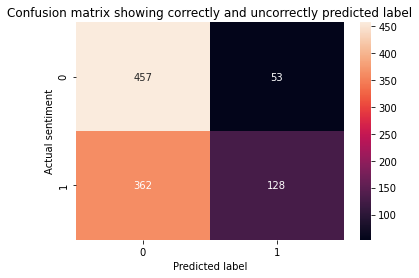

In [ ]:
cf_matrix = confusion_matrix(y_actual, pred_set)

plt.title('Confusion matrix showing correctly and uncorrectly predicted label')
sns.heatmap(cf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('Actual sentiment')